In [1]:
import optax
import equinox as eqx
from jax import Array, numpy as jnp, random as jr, tree_util as jtu, vmap

from matplotlib import pyplot as plt

from rssm import (
    init_model,
    init_post_state,
    forward_encoder,
    forward_decoder,
    forward_model,
    rollout_dynamics,
    rollout_dynamics_prior,
    mse_loss,
    kl_loss,
)


In [2]:
@eqx.filter_jit
def train_step(params, obs_seq, action_seq, optimizer, opt_state, key):
    def loss_fn(params):
        _forward = lambda o, a, k: forward_model(params, o, a, k)
        pred_seq, post, prior = vmap(_forward)(
            obs_seq, action_seq, jr.split(key, obs_seq.shape[0])
        )
        return mse_loss(obs_seq, pred_seq) + kl_loss(post.logits, prior.logits).mean()

    loss, grads = eqx.filter_value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = eqx.apply_updates(params, updates)
    return params, opt_state, loss



def init_dataset(key: jr.PRNGKey, T: int, B: int) -> tuple[Array, Array]:
    t = jnp.linspace(0, 2 * jnp.pi, T)
    phases = jr.uniform(key, shape=(B,), minval=0, maxval=2 * jnp.pi)

    def per_batch(i):
        phase_i = phases[i]
        x = jnp.sin(t + phase_i)
        y = jnp.cos(t + phase_i)
        return jnp.stack([x, y], axis=-1)

    obs_seq = vmap(per_batch)(jnp.arange(B))
    action_seq = jnp.zeros((B, T, 1))
    return obs_seq, action_seq

In [ ]:
key = jr.PRNGKey(0)
key, model_key, data_key = jr.split(key, 3)

model = init_model(
    obs_dim=2,
    action_dim=1,
    embed_dim=64,
    state_dim=200,
    num_discrete=8,
    discrete_dim=8,
    hidden_dim=200,
    key=model_key,
)

optimizer = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(1e-3))
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

key, data_key = jr.split(key)
obs_seq, action_seq = init_dataset(data_key, T=50, B=50)


num_epochs = 500
for epoch in range(num_epochs):
    key, train_key = jr.split(key)
    model, opt_state, loss = train_step(
        model, obs_seq, action_seq, optimizer, opt_state, train_key
    )
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

Epoch 0, Loss: 1.0279
Epoch 100, Loss: 0.9995
Epoch 200, Loss: 0.3968
Epoch 300, Loss: 0.3740
Epoch 400, Loss: 0.3244


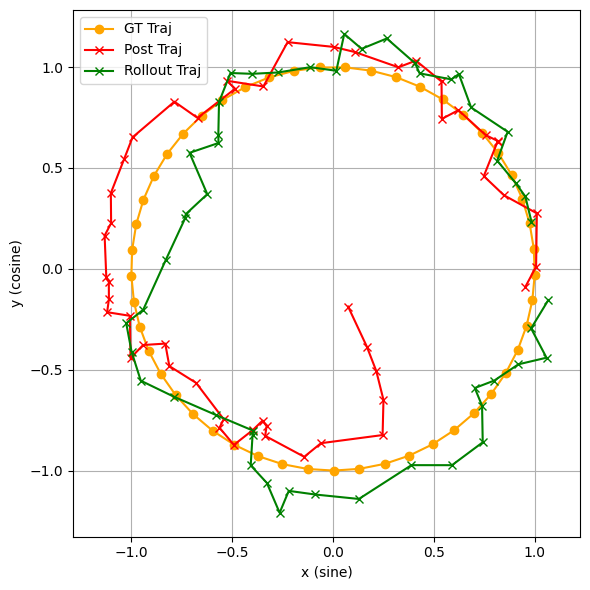

In [4]:
key, prior_key, rollout_key = jr.split(key, 3)

obs_slice = obs_seq[0]
action_slice = action_seq[0]


obs_embed_seq = vmap(lambda obs: forward_encoder(model.encoder, obs))(obs_slice)

post_seq, _ = rollout_dynamics(
    model.prior,
    model.posterior,
    obs_embed_seq,
    init_post_state(model),
    action_slice,
    rollout_key,
)
final_post = jtu.tree_map(lambda x: x[-1], post_seq)

rollout_seq = rollout_dynamics_prior(
    model.prior, final_post, action_slice, prior_key
)

post_obs = vmap(lambda s: forward_decoder(model.decoder, s))(post_seq)
rollout_obs = vmap(lambda s: forward_decoder(model.decoder, s))(rollout_seq)

plt.figure(figsize=(6, 6))
plt.plot(
    obs_slice[:, 0],
    obs_slice[:, 1],
    label="GT Traj",
    marker="o",
    color="orange",
)
plt.plot(
    post_obs[:, 0],
    post_obs[:, 1],
    label="Post Traj",
    marker="x",
    color="red",
)
plt.plot(
    rollout_obs[:, 0],
    rollout_obs[:, 1],
    label="Rollout Traj",
    marker="x",
    color="green",
)
plt.legend()
plt.xlabel("x (sine)")
plt.ylabel("y (cosine)")
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.show()